# Small World Graphs

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [3]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [4]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [5]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [6]:
lattice = make_ring_lattice(10, 4)

Writing chap03-1.pdf
Writing chap03-1.png


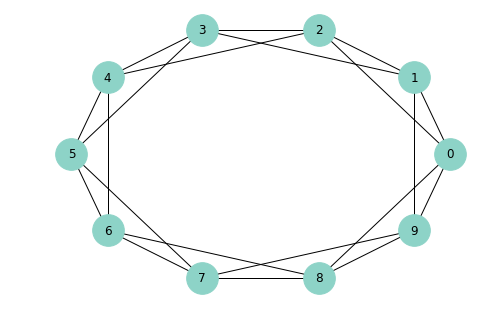

In [7]:
nx.draw_circular(lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)

thinkplot.save('chap03-1', clf=False)

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=3` or `k=5`.

## WS graph

To make a WS graph, you start with a ring lattice and then rewire.

In [8]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [9]:
def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

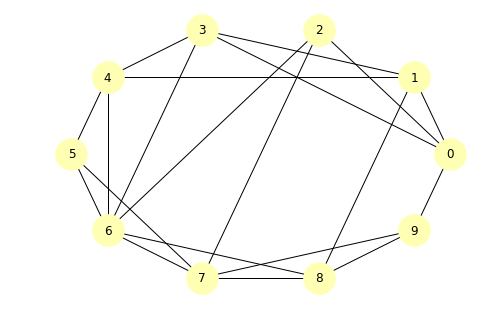

In [10]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color=COLORS[1], 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [11]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

Writing chap03-2.pdf
Writing chap03-2.png


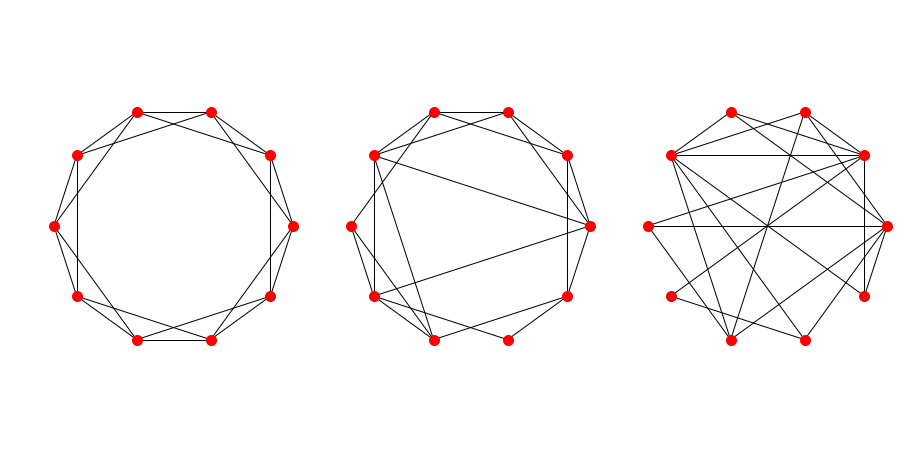

In [12]:
n = 10
k = 4
ns = 100

thinkplot.preplot(cols=3)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.tight_layout()
thinkplot.save('chap03-2', clf=False)

**Exercise:** What is the order of growth of `rewire`?

In [13]:
# Solution

"""The loop executes once for each edge.  Inside the loop, everything is constant
time except computing `choices`, which is linear in `n`.  So the total run time is 
`O(nm)`.""";

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [14]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [15]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [16]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [17]:
clustering_coefficient(lattice)

0.5

Correct.

In [18]:
%timeit clustering_coefficient(lattice)

126 µs ± 3.43 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.  Is it faster?

In [19]:
# Solution

def node_clustering(G, u):
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    edges = [G.has_edge(v, w) for v, w in all_pairs(neighbors)]
    return np.mean(edges)

clustering_coefficient(lattice)

0.5

In [20]:
%timeit clustering_coefficient(lattice)

337 µs ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

In [21]:
# Solution

"""`clustering_coefficient` calls `node_clustering` once for each node.  
`node_clustering` is quadratic in `k`, the number of neighbors.

In a complete graph, `k = n-1`, so `node_clustering` is `O(n^2)` and 
`clustering_coefficient` is `O(n^3)`.

But in a ring lattice, or any other graph where `k` is not proportional to `n`, 
`clustering_coefficient` is `O(k^2 n)`.
""";

## Path length

The following function computes path lengths between all pairs of nodes

In [22]:
def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            yield dist

The characteristic path length is the mean path length for all pairs.

In [23]:
def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

On a complete graph, the average path length should be 1

In [24]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)

0.9

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [25]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.4

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [26]:
# Solution

lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)

1.5

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [27]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes a few seconds on my computer:

In [28]:
%time run_one_graph(1000, 10, 0.01)

8.162078 0.6428959595959596
CPU times: user 5.26 s, sys: 4 ms, total: 5.26 s
Wall time: 5.26 s


(8.162078, 0.6428959595959596)

Now we'll run it with a range of values for `p`.

In [29]:
ps = np.logspace(-4, 0, 9)
print(ps)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [30]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns:
    """
    res = []
    for p in ps:
        print(p)
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        print(means)
        res.append(means)
    return np.array(res)

Here are the raw results.  Warning: this takes a few minutes to run.

In [31]:
%time res = run_experiment(ps)

0.0001
40.57323 0.6662065656565656
50.4 0.6666666666666665
50.4 0.6666666666666665
42.339582 0.6662065656565656
50.4 0.6666666666666665
47.164194 0.6664232323232322
50.4 0.6666666666666665
49.967736 0.6661343434343433
40.016814 0.6662787878787878
50.4 0.6666666666666665
50.4 0.6666666666666665
50.4 0.6666666666666665
50.4 0.6666666666666665
39.767096 0.6656742424242422
37.91298 0.6659631313131312
50.208114 0.6661343434343433
50.4 0.6666666666666665
39.697288 0.6663510101010099
50.4 0.6666666666666665
50.4 0.6666666666666665
[47.1023517   0.66643528]
0.00031622776601683794
38.463862 0.6663510101010099
32.58725 0.6654252525252525
37.205762 0.665890909090909
26.609504 0.6653585858585858
36.489624 0.6660353535353534
34.631614 0.6656020202020202
41.650582 0.6662787878787878
45.419386 0.666179797979798
33.514678 0.6661075757575756
38.557846 0.6662787878787878
32.04731 0.6651484848484848
33.337198 0.6656020202020202
38.758942 0.6662787878787877
45.688598 0.6662787878787878
43.300572 0.6657464

In [32]:
res

array([[4.71023517e+01, 6.66435278e-01],
       [3.83981881e+01, 6.65946869e-01],
       [2.76171755e+01, 6.64674596e-01],
       [1.60545862e+01, 6.60861717e-01],
       [8.95225810e+00, 6.47725043e-01],
       [6.03868970e+00, 6.09322277e-01],
       [4.49860480e+00, 4.99661407e-01],
       [3.66346760e+00, 2.61061740e-01],
       [3.26477497e+00, 1.31807846e-02]])

Let's get the results into a form that's easy to plot.

In [67]:
L, C = np.transpose(res)

In [68]:
L

array([47.1023517 , 38.3981881 , 27.6171755 , 16.0545862 ,  8.9522581 ,
        6.0386897 ,  4.4986048 ,  3.6634676 ,  3.26477497])

In [69]:
C

array([0.66643528, 0.66594687, 0.6646746 , 0.66086172, 0.64772504,
       0.60932228, 0.49966141, 0.26106174, 0.01318078])

And normalize them so they both start at 1.0

In [70]:
L /= L[0]
C /= C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

Writing chap03-3.pdf
Writing chap03-3.png


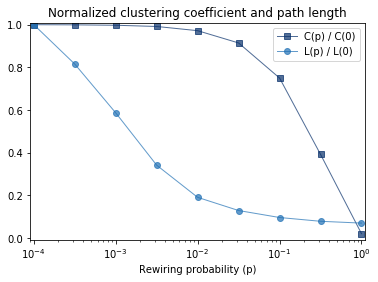

In [71]:
thinkplot.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
thinkplot.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
thinkplot.config(xlabel='Rewiring probability (p)', xscale='log',
                 title='Normalized clustering coefficient and path length',
                 xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

thinkplot.save('chap03-3', clf=False)

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [38]:
lattice = make_ring_lattice(10, 4)

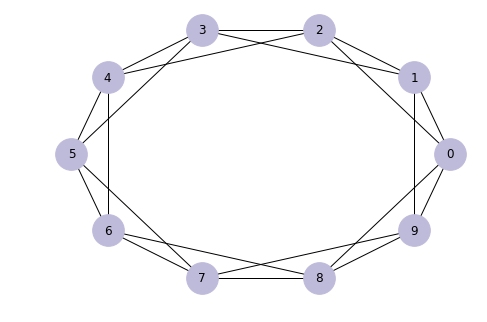

In [39]:
nx.draw_circular(lattice, 
                 node_color=COLORS[2], 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [40]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [41]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [42]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) - seen
            queue.extend(neighbors)
    return seen

It works, too.

In [43]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [44]:
def shortest_path_dijkstra(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [45]:
lattice = make_ring_lattice(10, 4)

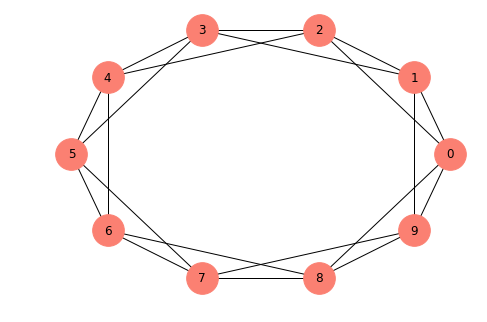

In [46]:
nx.draw_circular(lattice, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [47]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

And here's the result from NetworkX:

In [48]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

They are the same:

In [49]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [50]:
# Solution

lattice = make_ring_lattice(1000, 10)
d = shortest_path_dijkstra(lattice, 0)

from operator import itemgetter
node, dist = sorted(d.items(), key=itemgetter(1))[-1]
node, dist

(501, 100)

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [51]:
# Solution

# Here's `adjacent_edges` again for comparison:

def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

In [52]:
# Solution

# And here's a function that computes edges that connect each
# node to the one half-way around the circle

def opposite_edges(nodes):
    """Enumerates edges that connect opposite nodes."""
    n = len(nodes)
    for i, u in enumerate(nodes):
        j = i + n//2
        v = nodes[j % n]
        yield u, v

In [53]:
# Solution

# Now we can make regular graphs.

def make_regular_graph(n, k):
    """Makes graph with `n` nodes where all nodes have `k` neighbors.
    
    Not possible if both `n` and `k` are odd.
    """
    # a is the number of adjacent edges
    # b is the number of opposite edges (0 or 1)
    a, b = divmod(k, 2)
    
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, a))
    
    # if k is odd, add opposite edges
    if b:
        if n%2:
            msg = "Can't make a regular graph if n and k are odd."
            raise ValueError(msg)
        G.add_edges_from(opposite_edges(nodes))
    return G

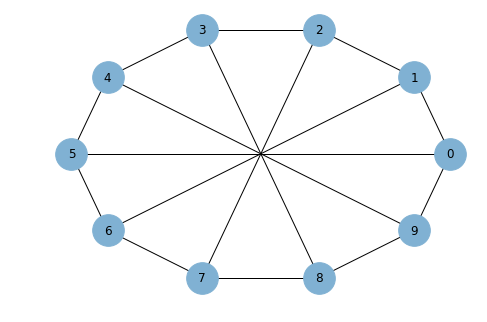

In [54]:
# Solution

# Here's an example.

regular = make_regular_graph(10, 3)

nx.draw_circular(regular, 
                 node_color=COLORS[4], 
                 node_size=1000, 
                 with_labels=True)

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [55]:
def plain_bfs(G, start):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [56]:
# Solution

lattice = make_ring_lattice(1000, 10)

In [57]:
# Solution

%timeit len(reachable_nodes_bfs(lattice, 0))

3.1 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
# Solution

%timeit len(plain_bfs(lattice, 0))

2.38 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
# Solution

#The version from NetworkX is faster.

#Here's a version of Dijkstra's algorithm that works the same way:

def plain_shortest_path(G, source):
    """A fast version of Dijkstra's algorithm for equal edges."""
    new_dist = 0
    dist = {}
    nextlevel = {source}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in dist:
                dist[v] = new_dist
                nextlevel.update(G[v])
        new_dist += 1
    return dist

In [60]:
# Solution

#It gets the right answers

lattice = make_ring_lattice(1000, 10)
d1 = shortest_path_dijkstra(lattice, 0)
d2 = plain_shortest_path(lattice, 0)
d1 == d2

True

In [61]:
# Solution

# And it is substantually faster than the version that uses a deque.

%timeit shortest_path_dijkstra(lattice, 0)

2.97 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
# Solution

%timeit plain_shortest_path(lattice, 0)

2.15 ms ± 212 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
# Solution

%timeit nx.shortest_path_length(lattice, 0)

5.2 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [64]:
def bfs(G, start):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [start]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in G[curr_node]
                     if c not in visited and c not in queue)
    return visited

In [65]:
# Solution

"""The first performance error is using `pop(0)` on a list, which is linear in
the length of the list.  The second error is checking whether the children are 
in queue, which is also linear in the length of the list.  In the worst case, 
a completely connected graph, the queue loop runs `n` times, and each time we 
have to check `n` nodes to see if they are in a list with `n` elements, so the 
total run time is `O(n^3)`, which is really terrible.

By the way, I did not make this example up.  It used to be on 
[the Wikipedia page for BFS](https://en.wikipedia.org/wiki/Breadth-first_search).
In fact, if you search the Internet for Python implementations of BFS, many of 
them contain at least one performance error.
"""
None

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [66]:
# Solution

# Here's the broken version:

def shortest_path_dfs(G, start):
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.pop()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

#Sure enough, it gets the answers wrong

lattice = make_ring_lattice(10, 4)
d1 = shortest_path_dfs(lattice, 0)
print(d1)
d2 = nx.shortest_path_length(lattice, 0)
print(d2)
d1 == d2

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 7: 2, 5: 3, 6: 3, 4: 4, 3: 5}
{0: 0, 1: 1, 2: 1, 8: 1, 9: 1, 3: 2, 4: 2, 6: 2, 7: 2, 5: 3}


False